# Lab report - A General Purpose JAX-based Controller
### AI Programming (IT-3105) - Spring 2025

Péter Czumbel - pczumbel@gmail.com

In [1]:
from helper import Helper
import config

The following parameters for the training of the controller are constant through all the runs:

| Param           | Value | Description                             |
|-----------------|-------|-----------------------------------------|
| DT              | 1.0   | simulation timestep size                |
| LR              | 0.01  | learning rate                           |
| EPOCHS          | 1000  | number of training epochs               |
| STEPS_PER_EPOCH | 100   | number of simulation steps in one epoch |
| JIT             | True  | turn on JIT compiler                    |


## Run 1: Bathtub and PID controller

Controller parameters:

| Param | Value | Description               |
|-------|-------|---------------------------|
| KP    | 1.0   | Initial proportional term |
| KI    | 0.0   | Initial integral term     |
| KD    | 0.0   | Initial derivative term   |

Plant parameters:

| Param             | Value | Description                                      |
|-------------------|-------|--------------------------------------------------|
| INITIAL_STATE     | 4.0   | Initial water level                              |
| TARGET            | 2.0   | Target water level                               |
| AREA              | 1.0   | Bathtub cross-sectional area                     |
| EXIT_AREA         | 0.01  | Drain cross-sectional area                       |
| DISTURBANCE_RANGE | 0.05  | Range of disturbance (uniform between -x and +x) |

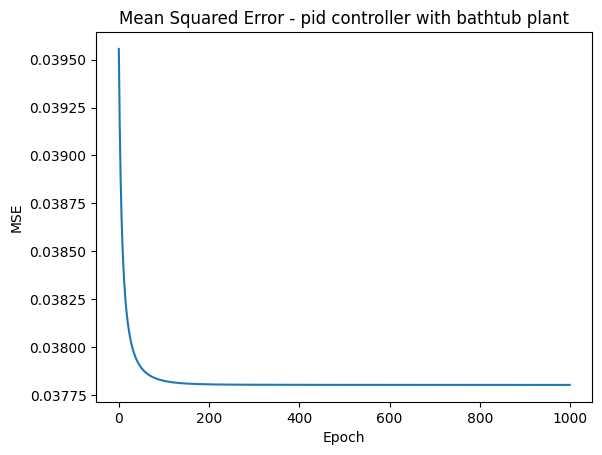

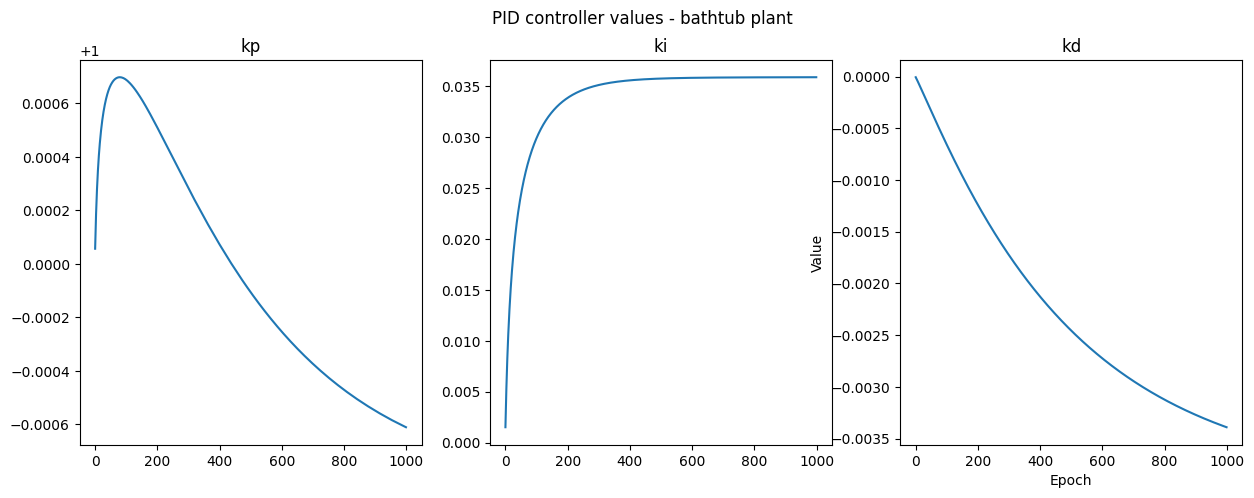

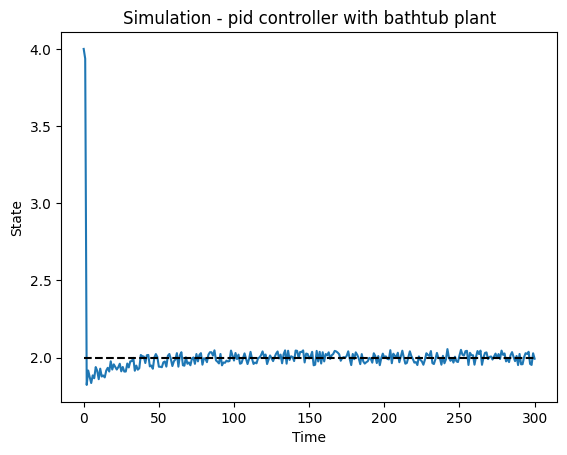

In [2]:
config.plant = 'bathtub'
config.controller = 'pid'
helper = Helper(config)
helper.demo()

Looking at the graphs above, we can tell that the controllers MSE stopped improving after about 200 epochs. Out of the 3 K values, Ki set in at a constant value of $0.0035$, while the other 2 values kept decreasing during each epoch.

The third graph shows a simulation of the bathtub level being controlled by the PID controller over 300 steps. The controller is clearly working, the level is stable and close to the target, despite the disturbances.

## Run 2: Bathtub with NN controller

Controller parameters:

| Param       | Value            | Description                                                   |
|-------------|------------------|---------------------------------------------------------------|
| layer_init  | 'glorot_uniform' | Weight initialization method                                  |
| param_range | [-1.0, 1.0]      | Weight range (ignored if method is not None)                  |
| LAYER_SIZES | [3, 10, 1]       | List of network layer sizes. Must start with 3 and end with 1 |
| ACTIVATION  | 'relu'           | Activation function of the layers inside the network          |

Plant parameters:

| Param             | Value | Description                                      |
|-------------------|-------|--------------------------------------------------|
| INITIAL_STATE     | 4.0   | Initial water level                              |
| TARGET            | 2.0   | Target water level                               |
| AREA              | 1.0   | Bathtub cross-sectional area                     |
| EXIT_AREA         | 0.01  | Drain cross-sectional area                       |
| DISTURBANCE_RANGE | 0.05  | Range of disturbance (uniform between -x and +x) |

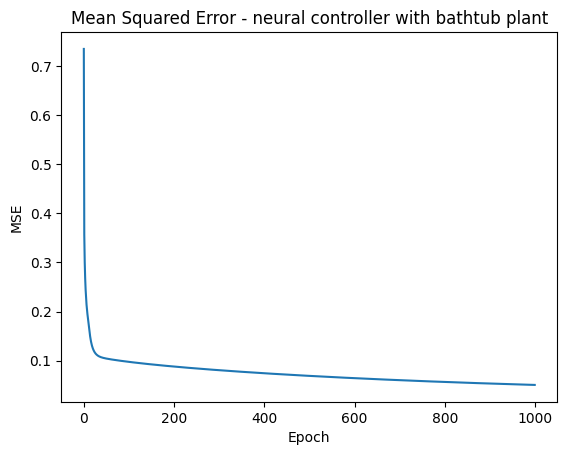

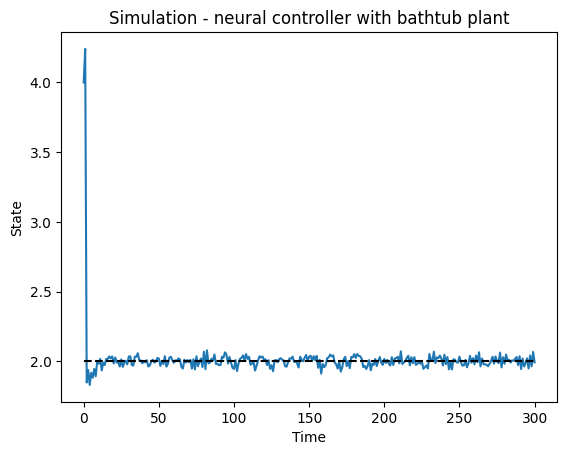

In [3]:
config.plant = 'bathtub'
config.controller = 'neural'
helper = Helper(config)
helper.demo()

The MSE of the neural network based controller keeps slowly but visibly decreasing even after 1000 epochs - maybe a higher learning rate could lead to faster convergence? The controller has 3 neurons in its input layer, 10 in a hidden layer and 1 in its output layer. With just 3 layers its a small net, but the size of the middle layer probably could have been reduced even more. Regardless, the simulation shows that the controller is working, the water level is steady at its target. The neural controller has the same configuration across all runs.

Sometimes (especially at higher layer numbers and sizes) the neural controller sometimes finds a local optimum, where the water level oscillates around the target.

## Run 3: Cournot competition with PID controller

Controller parameters:

| Param | Value | Description               |
|-------|-------|---------------------------|
| KP    | 1.0   | Initial proportional term |
| KI    | 0.0   | Initial integral term     |
| KD    | 0.0   | Initial derivative term   |

Plant parameters:

| Param             | Value | Description                                       |
|-------------------|-------|---------------------------------------------------|
| INITIAL_PROFIT    | 0.0   | Initial profit of producer 1                      |
| TARGET            | 1.5   | Target profit of producer 1                       |
| P_MAX             | 4.0   | Highest possible price                            |
| COST_1            | 0.5   | Producer 1 marginal cost                          |
| COST_2            | 0.5   | Producer 2 marginal cost                          |
| Q1                | 0.5   | Producer 1 initial production                     |
| Q2                | 0.5   | Producer 2 initial production                     |
| DISTURBANCE_RANGE | 0.05  | Range of disturbance (uniform between -x and +x)  |

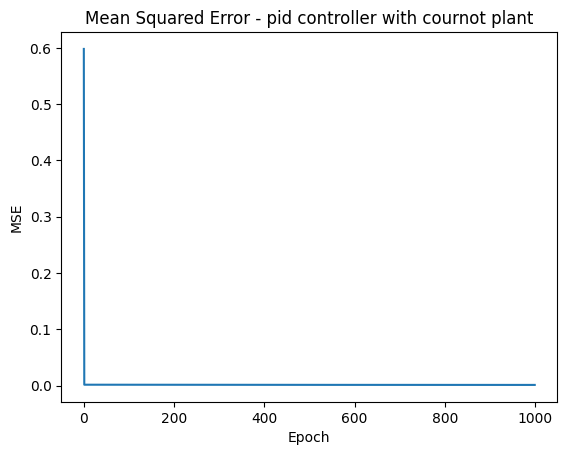

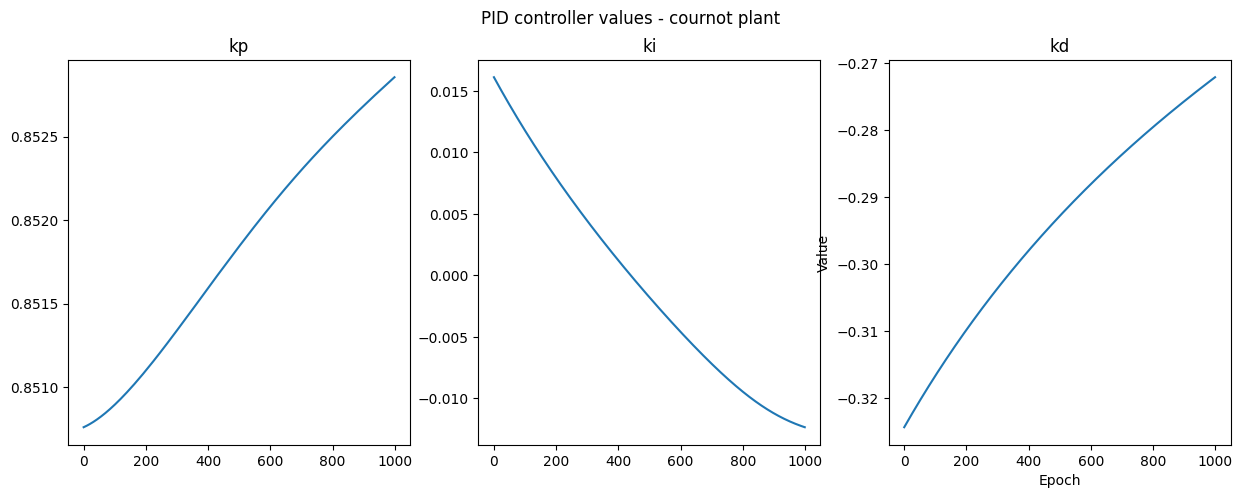

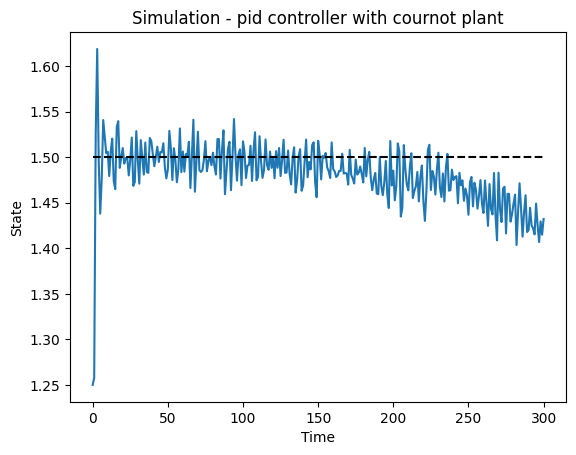

In [4]:
config.plant = 'cournot'
config.controller = 'pid'
helper = Helper(config)
helper.demo()

Looking at the first graph, we can see that the model very quicky finds a good set of parameters. On the simulation graph however, the controller seems to lose control after around 200 steps. In the training loop, the epochs only consist of 100 steps, perhaps it would be beneficial to increase that value, but its also possible that the deviation from the target is only caused by the disturbance, and its temporary.

## Run 4: Cournot competition with NN controller

Controller parameters:

| Param       | Value            | Description                                                   |
|-------------|------------------|---------------------------------------------------------------|
| layer_init  | 'glorot_uniform' | Weight initialization method                                  |
| param_range | [-1.0, 1.0]      | Weight range (ignored if method is not None)                  |
| LAYER_SIZES | [3, 10, 1]       | List of network layer sizes. Must start with 3 and end with 1 |
| ACTIVATION  | 'relu'           | Activation function of the layers inside the network          |

Plant parameters:

| Param             | Value | Description                                       |
|-------------------|-------|---------------------------------------------------|
| INITIAL_PROFIT    | 0.0   | Initial profit of producer 1                      |
| TARGET            | 1.5   | Target profit of producer 1                       |
| P_MAX             | 4.0   | Highest possible price                            |
| COST_1            | 0.5   | Producer 1 marginal cost                          |
| COST_2            | 0.5   | Producer 2 marginal cost                          |
| Q1                | 0.5   | Producer 1 initial production                     |
| Q2                | 0.5   | Producer 2 initial production                     |
| DISTURBANCE_RANGE | 0.05  | Range of disturbance (uniform between -x and +x)  |

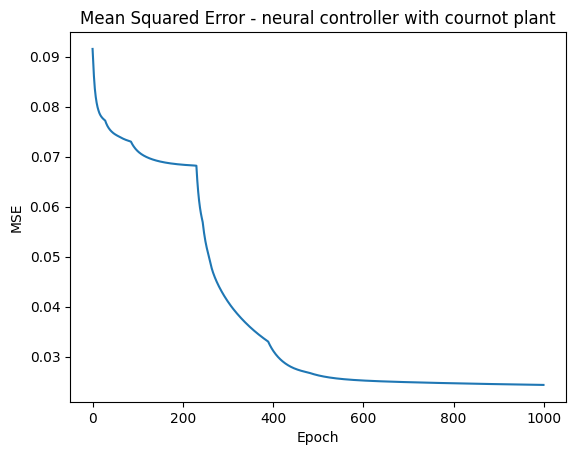

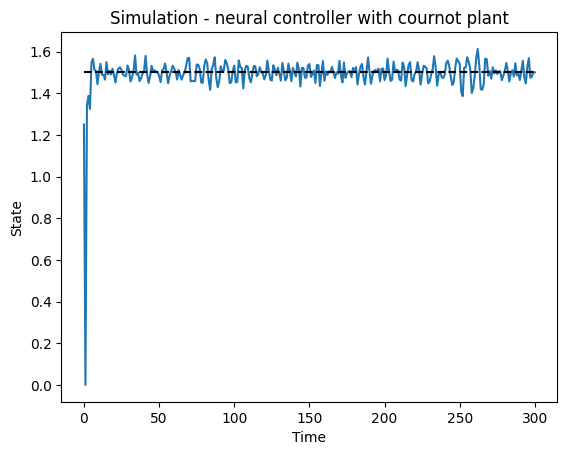

In [5]:
config.plant = 'cournot'
config.controller = 'neural'
helper = Helper(config)
helper.demo()

The first graph of this run shows quite an interesting learning curve, it looks as if the model almost got stuck in local optimums, but found its way out in the end. On this plant, the neural controller also had a tendency to oscillate around the target value. Despite falling down to 0 at the fist step, this controller managed to hold the profit steady around the target for all steps of the simulation, performing better than the conventional PID controller.

## Custom model description - temperature control

The temperature plant models the thermal dynamics of a room, where the temperature T(t) is affected by heat loss to the environment and heating input. The system can be described by the following first-order differential equation:

$$\frac{dT}{dt}=-\alpha(T-T_{\text{env}})+\beta P$$

where:
- $T(t)$ is the room temperature at time $t$
- $​T_{\text{env}}$ is the ambient temperature.
- $\alpha$ is the heat loss coefficient (how quickly heat dissipates).
- $\beta$ is the heating efficiency (how effectively the heater increases temperature).
- $P$ is the heating power input (control value) constrained between 0 and 100.

At equilibrium $\frac{dT}{dt} = 0$, the room temperature reaches a steady state:

$$T_{\text{steady}} = T_{\text{env}} + \frac{\beta P}{\alpha}$$

which shows that increasing heating power $P$ raises the steady-state temperature.

## Run 5: Temperature control with PID controller

Controller parameters:

| Param | Value | Description               |
|-------|-------|---------------------------|
| KP    | 1.0   | Initial proportional term |
| KI    | 0.0   | Initial integral term     |
| KD    | 0.0   | Initial derivative term   |

Plant parameters:

| Param             | Value | Description                                      |
|-------------------|-------|--------------------------------------------------|
| T_INITIAL         | 14.0  | Initial temperature                              |
| TARGET            | 22.0  | Target temperature                               |
| DISTURBANCE_RANGE | 2.0   | Range of disturbance (uniform between -x and +x) |
| ALPHA             | 0.1   | Heat loss coefficient                            |
| BETA              | 0.5   | Heating efficiency                               |
| T_ENV             | 10.0  | Ambient temperature                              |

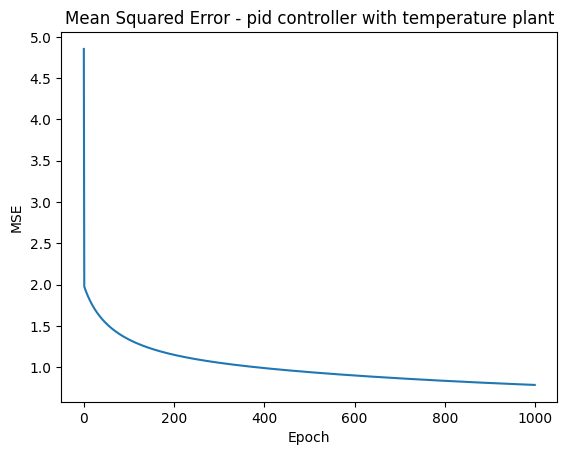

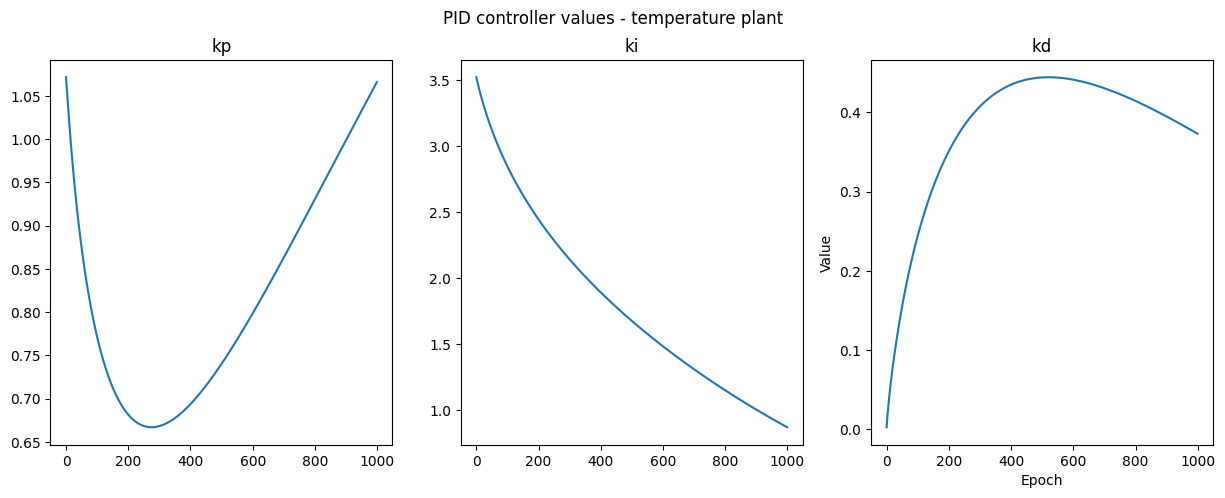

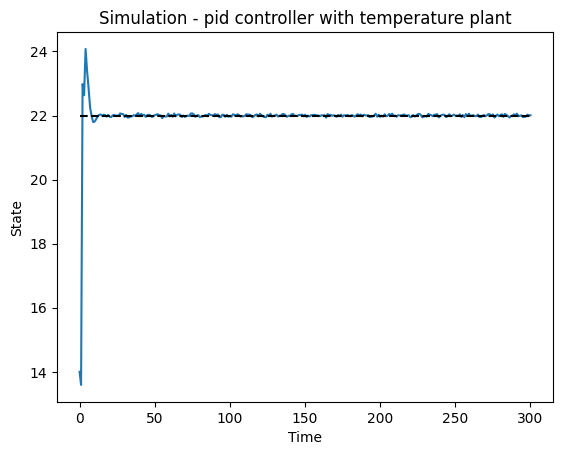

In [6]:
config.plant = 'temperature'
config.controller = 'pid'
helper = Helper(config)
helper.demo()

The PID controller handled this task quite well, although it still seemed to be learning after 1000 epochs. A higher learning rate would probably fix that. Controlling this plant is simpler than the other two, so it is no surprise that the controller worked well in the simulation.

During training, the K values go through an interesting trajectory - quite different than the other two plants - and they dont seem to be converging to anything.

## Run 6: Temperature control with NN controller

Controller parameters:

| Param       | Value            | Description                                                   |
|-------------|------------------|---------------------------------------------------------------|
| layer_init  | 'glorot_uniform' | Weight initialization method                                  |
| param_range | [-1.0, 1.0]      | Weight range (ignored if method is not None)                  |
| LAYER_SIZES | [3, 10, 1]       | List of network layer sizes. Must start with 3 and end with 1 |
| ACTIVATION  | 'relu'           | Activation function of the layers inside the network          |

Plant parameters:

| Param             | Value | Description                                      |
|-------------------|-------|--------------------------------------------------|
| T_INITIAL         | 14.0  | Initial temperature                              |
| TARGET            | 22.0  | Target temperature                               |
| DISTURBANCE_RANGE | 2.0   | Range of disturbance (uniform between -x and +x) |
| ALPHA             | 0.1   | Heat loss coefficient                            |
| BETA              | 0.5   | Heating efficiency                               |
| T_ENV             | 10.0  | Ambient temperature                              |

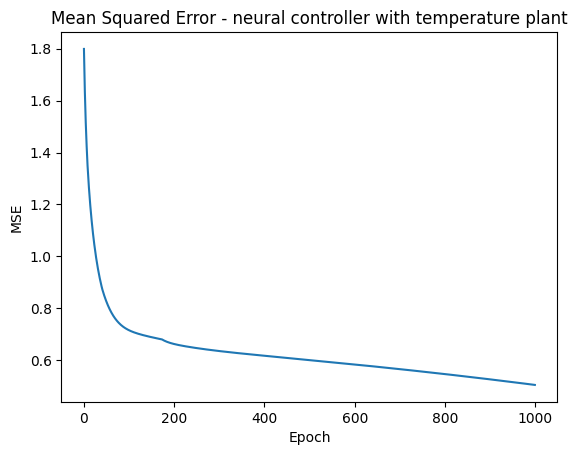

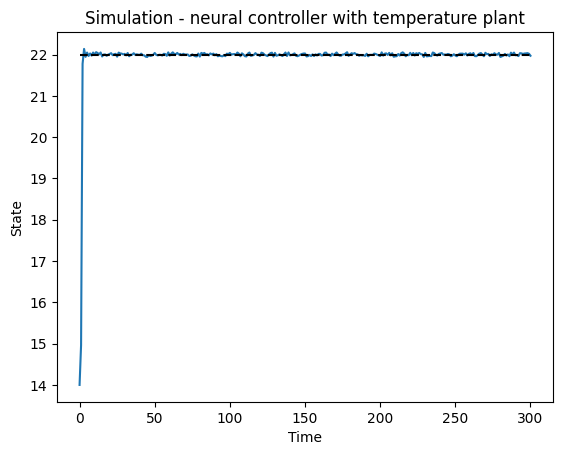

In [7]:
config.plant = 'temperature'
config.controller = 'neural'
helper = Helper(config)
helper.demo()

The neural controller reached a lower MSE on this task, then the PID controller, and its clearly still improving after 1000 epochs. The simulation shows that the plant reaches its target in just 2 timesteps, and holds it steadily throughout all the steps. Since this is a quite simple problem, the size of the neural net probably could have been much smaller, and could have been ran with a higher learning rate.